# Identifying the key drivers of electricity price spikes in the Australian National Electricity Market: A Machine Learning Approach

## Introduction
The next federal election in Australia is scheduled for May 3, 2025, and one of the most hotly debated topics is the surge in electricity prices over the past three years. The Coalition blames renewable energy supported under the Capacity Investment Scheme (CIS), which is Labor’s main energy policy. Meanwhile, Labor attributes the elevated prices in the National Electricity Market (NEM) to fossil gas generation.

From my experience working in the electricity market, it's commonly understood that natural gas often acts as the "peaker" in the system. However, I believe it's worth verifying this assumption using a machine learning approach — one that doesn’t start with any built-in bias.

This study aims to systematically investigate the operational and market conditions contributing to high wholesale electricity prices (defined as prices above the 95th percentile) and to identify which fuel types and time-based patterns are associated with these spikes in each region in the NEM. Due to the complexity of the dataset, I plan to use two supervised machine learning techniques — Random Forest and XGBoost — to classify peak and non-peak electricity prices based on various features, such as fuel type, the dispatch proportion of each fuel type, and temporal patterns. These models will be trained on the data, and the optimal model will be selected based on accuracy metrics.

The Jupyter notebook, report, and slides for this work have been uploaded to GitHub at the link below:

🔗 **[Download the final project](https://github.com/HauNguyen8689/Introduction-to-Machine-Learning-Supervised-Learning)**

---

## 1. Objective

The National Electricity Market (NEM) in Australia is a wholesale electricity market that spans five interconnected regions: New South Wales (including the Australian Capital Territory), Queensland, Victoria, South Australia, and Tasmania. In the NEM, supply and demand are matched in real-time through a process known as dispatch and settlement. This process is managed by the Australian Energy Market Operator (AEMO) and operates at five-minute intervals to ensure efficient market operation, optimal resource utilization, and the stability and reliability of the electricity grid.

Due to the complexity of the market, identifying the key drivers of price spikes can be challenging. Therefore, this analysis aims to classify high-price events (defined as prices above the 95th percentile) and determine the conditions under which these events are most likely to occur, focusing on:

- The contribution of each fuel type to electricity dispatch  
- The impact of temporal patterns (Hour, Day of Week, Month)  
- Classifying these contributors as **"Peaker"** (associated with price spikes) and **"Non-Peaker"** (associated with normal prices)

---

## 2. Data Overview

### **Data Sources**  
The historical electricity data was collected from the AEMO website, covering one year from **April 1, 2024, to March 31, 2025**. It includes:

- Regional demand and prices  
- Generator dispatch and capacity data by DUID  
- Generator metadata, including fuel type and region  

The data is originally recorded at 5-minute intervals and has been aggregated to hourly intervals for convenience. Hourly resolution is considered sufficient to capture price spikes.

The dataset is stored in CSV format and has been uploaded to Kaggle for easy access and use in further analysis or projects.  
🔗 **[Download the dataset from Kaggle](https://www.kaggle.com/datasets/baohoangnguyen/nem-hourly-dispatch)**

---


In [20]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [5]:
############################################ Data Processing ##############################################

# Load data
df = pd.read_csv("Data.csv",index_col=False)

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Clean data set
# Drop NA values
df = df.dropna()

# Convert to float type
df['Capacity'] = df['Capacity'].replace({',': ''}, regex=True).astype(float)
df['Dispatch'] = df['Dispatch'].replace({',': ''}, regex=True).astype(float)
df['Demand'] = df['Demand'].replace({',': ''}, regex=True).astype(float)

# Remove Biomass fuel type due to tiny scale
df = df[~df['FuelType'].isin(['Biomass'])]

# Group by fuel type
df1 = df.drop(columns=['DUID'])
df2 = df1.groupby(['Date', 'FuelType','Region']).agg({
    'Dispatch': 'sum',
    'Capacity': 'sum',
    'Price': 'first', 
    'Demand': 'first'}).reset_index()

# Calculate the proportion of dispatch by fuel type and hour
df3 = df[['Date','Region','Dispatch']]
df3 = df3.groupby(['Date', 'Region']).agg({
    'Dispatch': 'sum'}).reset_index()

df3 = df3.rename(columns={'Dispatch': 'Total_Dispatch'})
df_run = df2.merge(df3, on=['Date','Region'], how='left')
df_run['Prop'] = df_run['Dispatch']/df_run['Total_Dispatch']
df_run['Prop'] = np.ceil(df_run['Prop'].clip(lower=0) * 100)

# Create Hour, Month and Day of Week columns
df_run['Hour'] = df_run['Date'].dt.hour
df_run['Month'] = df_run['Date'].dt.month
df_run['DayofWeek'] = df_run['Date'].dt.dayofweek

# Explore data
df_run.info()
df_run.describe()
df_run

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276201 entries, 0 to 276200
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            276201 non-null  datetime64[ns]
 1   FuelType        276201 non-null  object        
 2   Region          276201 non-null  object        
 3   Dispatch        276201 non-null  float64       
 4   Capacity        276201 non-null  float64       
 5   Price           276201 non-null  float64       
 6   Demand          276201 non-null  float64       
 7   Total_Dispatch  276201 non-null  float64       
 8   Prop            276201 non-null  float64       
 9   Hour            276201 non-null  int64         
 10  Month           276201 non-null  int64         
 11  DayofWeek       276201 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 27.4+ MB


,Date,FuelType,Region,Dispatch,Capacity,Price,Demand,Total_Dispatch,Prop,Hour,Month,DayofWeek
0,2024-04-01,Battery,QLD1,0.000000,2.00,54.678226,5763.012727,5743.074423,0.0,0,4,0
1,2024-04-01,Black coal,NSW1,5642.017096,8305.00,53.651115,6442.665455,6229.116325,91.0,0,4,0
2,2024-04-01,Black coal,QLD1,4914.817451,8130.00,54.678226,5763.012727,5743.074423,86.0,0,4,0
3,2024-04-01,Brown coal,VIC1,4094.037070,4820.00,48.828977,3784.116364,5414.901927,76.0,0,4,0
4,2024-04-01,Hydro,NSW1,83.099632,1957.00,53.651115,6442.665455,6229.116325,2.0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
276196,2025-04-01,Wind,NSW1,1248.616353,2477.69,57.010000,6951.660000,6309.649149,20.0,0,4,1
276197,2025-04-01,Wind,QLD1,447.097580,1945.97,62.410440,6372.380000,6040.414288,8.0,0,4,1
276198,2025-04-01,Wind,SA1,1151.448270,2410.14,23.689680,1410.230000,1234.712880,94.0,0,4,1
276199,2025-04-01,Wind,TAS1,76.795559,434.10,47.120000,997.730000,605.620315,13.0,0,4,1


### **Data Description**

The original dataset contained approximately 3.5 million observations. It was then cleaned and aggregated by fuel type. The final dataset used for modeling consists of **276,201 observations** with the following variables:

**Dependent Variable (Target):**  
Electricity prices will be classified during model execution as follows:  
- `Peaker = 1` for prices ≥ 95th percentile  
- `Non_Peaker = 0` for prices < 95th percentile

**Independent Variables (Features):**  
- `Hour`: Hour of day (0–23)  
- `DayofWeek`: Day of the week (0 = Monday to 6 = Sunday)  
- `Month`: Month of the year (1–12)  
- `Prop`: Proportion of total dispatch by each fuel type  
- `FuelType`: Fuel type (coal, gas, hydro, wind, solar, battery etc.)  
- `Region`: One of the 5 NEM regions. The model will be run separately for each region due to differences in market characteristics.

Other variables such as `Dispatch`, `Capacity`, `Total_Dispatch`, and `Demand` are excluded during model execution, as their information is already captured by the `Prop` variable.

The charts below illustrate how electricity prices fluctuate based on the time of day, day of the week, and month. These temporal patterns can reveal important insights into demand cycles, operational constraints, and market behaviors within the NEM.

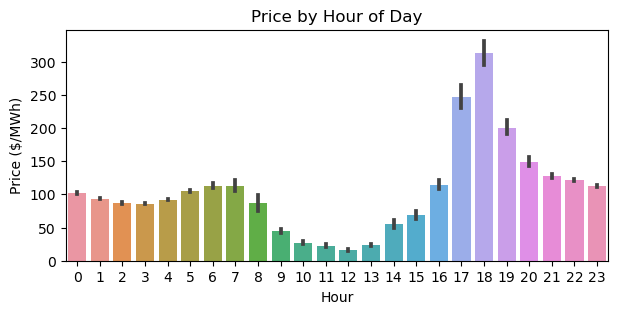

In [11]:
########################################## Explore data and visualization ############################################
# Copy data for visualisation
df_plot = df_run.copy()
df_plot['DayofWeek'] = df_plot['DayofWeek'].map(lambda x: calendar.day_name[x])

# Plot price by hour
plt.figure(figsize=(7, 3))
sns.barplot(data=df_plot, x='Hour', y='Price')
plt.title('Price by Hour of Day')
plt.ylabel('Price ($/MWh)')
plt.show()

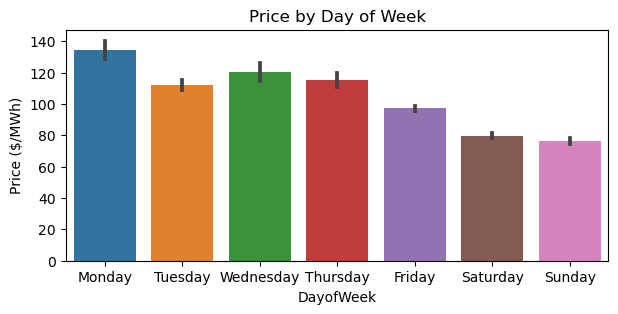

In [12]:
# Plot price by Day of week
plt.figure(figsize=(7, 3))
sns.barplot(data=df_plot, x='DayofWeek', y='Price')
plt.title('Price by Day of Week')
plt.ylabel('Price ($/MWh)')
plt.show()

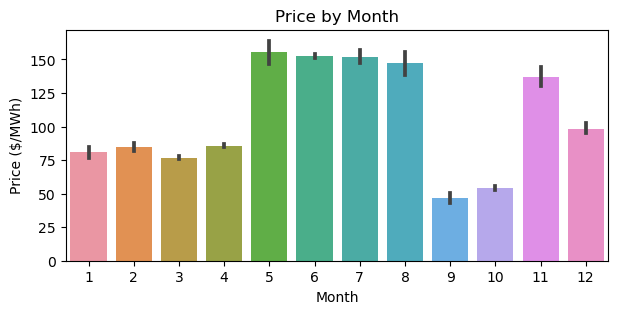

In [13]:
# Plot price by month
plt.figure(figsize=(7, 3))
sns.barplot(data=df_plot, x='Month', y='Price')
plt.title('Price by Month')
plt.ylabel('Price ($/MWh)')
plt.show()

### **Visualize price by region**

There are five regions in the NEM (NSW1, QLD1, SA1, TAS1, and VIC1), each with different market characteristics and subject to interconnector constraints. Therefore, the data will be split by region for model training in order to identify the most important features specific to each area. 

Below is a boxplot of prices in each region, with the 95th percentile values highlighted. It can be seen that the 95th percentile values are around $250 across regions.

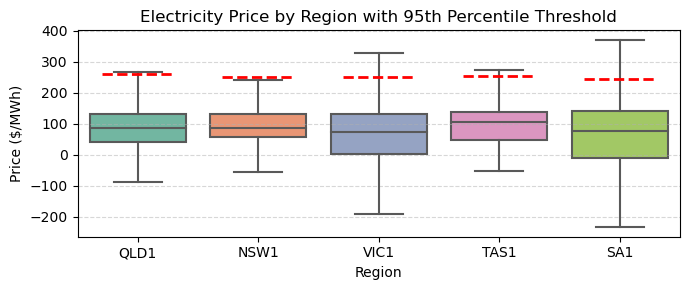

In [19]:
# Create boxplot of prices by region with 95th percentile
# Calculate 95th percentile by region
percentile_95 = df_plot.groupby('Region')['Price'].quantile(0.95).reset_index()
percentile_95.columns = ['Region', 'P95']

# Plot boxplot
plt.figure(figsize=(7, 3))
sns.boxplot(data=df_plot, x='Region', y='Price', showfliers=False, palette='Set2')

# Overlay 95th percentile line per region
for i, region in enumerate(percentile_95['Region']):
    p95_value = percentile_95[percentile_95['Region'] == region]['P95'].values[0]
    plt.plot([i - 0.3, i + 0.3], [p95_value, p95_value], color='red', linestyle='--', linewidth=2)

plt.title('Electricity Price by Region with 95th Percentile Threshold')
plt.ylabel('Price ($/MWh)')
plt.xlabel('Region')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 3. Methodology

This study uses supervised machine learning to classify high-price events in the NEM, defined as instances where electricity prices exceed the 95th percentile for each region. Two widely used tree-based classification algorithms — **Random Forest** and **XGBoost (Extreme Gradient Boosting)** — are applied to identify which factors (temporal and fuel-based) are most strongly associated with these price spikes.

### Data Splitting

To ensure the robustness of model training and evaluation, the dataset is split into training and testing sets:
- **80% for training**: Used to fit the models and perform hyperparameter tuning.
- **20% for testing**: Held out for evaluating the model's generalization ability on unseen data.

The split is done randomly but with a fixed seed to ensure reproducibility.

### Model Selection and Rationale

- **Random Forest**: An ensemble learning method that constructs multiple decision trees during training and outputs the class that is the mode of the predictions of individual trees. It helps reduce variance and avoids overfitting compared to a single decision tree.
  
- **XGBoost**: A gradient boosting framework that builds decision trees sequentially, where each tree tries to correct the errors made by the previous ones. XGBoost is known for its scalability, speed, and superior accuracy in many structured data problems.

These models are chosen for their robustness, ability to handle both numerical and categorical variables, and effectiveness in modeling complex, nonlinear relationships — which are expected in electricity market behavior.

### Hyperparameter Tuning

In this analysis, the focus is on tuning a single key hyperparameter: **`max_depth`**, which controls the maximum depth of the individual trees in both Random Forest and XGBoost. This parameter determines how deeply the tree can grow during training:

- Shallow trees (low max_depth) may underfit the data, capturing only general trends.
- Deep trees (high max_depth) can overfit by learning noise and outliers in the training set.

A range of depth values is tested for each model. The optimal depth is selected based on model performance on the test set.

### Model Evaluation

The primary metric used for model evaluation is **accuracy**. Accuracy is chosen for its interpretability and relevance in a classification task where the goal is to correctly identify whether a high-price event occurred.

After evaluating both models with different values of `max_depth`, the model that achieves the highest accuracy on the test set is selected as the optimal classifier. In addition to accuracy, feature importance scores are analyzed to interpret which variables contribute most to price spikes.

This methodology provides a systematic and transparent approach to uncovering the operational and temporal drivers behind extreme price events in the NEM.


In [21]:
################################### Training model and valuation on test set ################################################

for region in ['NSW1','QLD1','SA1','TAS1','VIC1']:
    print(f"\n--- {region} ---")
    
    # Filter by hour
    df_region = df_run[df_run['Region'] == region].copy()
    
    # Create target variable
    threshold = df_region['Price'].quantile(0.95)
    df_region['Peaker'] = (df_region['Price'] >= threshold).astype(int)
    
    # One-hot encode
    df_model = pd.get_dummies(df_region, columns=['FuelType'], drop_first=True)
    
    # Remove duplicates in df_model
    cols = ['Price', 'Date', 'Region','Dispatch','Demand','Total_Dispatch','Capacity']
    df_model = df_model.drop(columns=[col for col in cols if col in df_model.columns], errors='ignore')
    df_model = df_model.drop_duplicates()

    # Feature & Target
    drop_cols = ['Peaker']
    X = df_model.drop(columns=[col for col in drop_cols if col in df_model.columns], errors='ignore')
    y = df_model['Peaker']

    # Skip if insufficient data
    if len(X) < 20 or y.nunique() < 2:
        print(f"Not enough data or only one class for hour {hour}. Skipping.")
        continue

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # ========== XGBoost Classifier ==========
    xgb_param_grid = {'max_depth': range(3,7)}

    grid_xgb = GridSearchCV(
        XGBClassifier(random_state=42, eval_metric='logloss'),
        xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit model
    grid_xgb.fit(X_train, y_train)

    # Best model
    best_xgb = grid_xgb.best_estimator_

    # Accuracy scores
    train_acc_xgb = best_xgb.score(X_train, y_train)
    test_acc_xgb = best_xgb.score(X_test, y_test)

    # Feature importance
    feat_xgb = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_xgb.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(10)

    # ========== Random Forest ==========
    rf_param_grid = {'max_depth': range(3,7)}
    grid_rf = GridSearchCV(RandomForestClassifier(n_estimators=100, random_state=42),
                           rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_

    train_acc_rf = best_rf.score(X_train, y_train)
    test_acc_rf = best_rf.score(X_test, y_test)
    feat_rf = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_rf.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(10)

    # Choose better model
    if test_acc_rf > test_acc_xgb:
        model_name = 'Random Forest'
        best_params = grid_rf.best_params_
        train_acc = train_acc_rf
        test_acc = test_acc_rf
        top_features = feat_rf
    else:
        model_name = 'XGBoost'
        best_params = grid_xgb.best_params_
        train_acc = train_acc_xgb
        test_acc = test_acc_xgb
        top_features = feat_xgb

    # Append to results
    print(f"Price Threshold: {threshold}")
    print(f"Chosen Model: {model_name}")
    print(f"Best Params: {best_params}")
    print(f"Train Accuracy: {round(train_acc, 4)}")
    print(f"Test Accuracy: {round(test_acc, 4)}")
    print(top_features)
    print("-" * 40)


--- NSW1 ---
Price Threshold: 261.80498208333296
Chosen Model: XGBoost
Best Params: {'max_depth': 4}
Train Accuracy: 0.9367
Test Accuracy: 0.9337
                  Feature  Importance
1                    Hour    0.218478
2                   Month    0.167240
6    FuelType_Natural gas    0.113929
5          FuelType_Hydro    0.108677
7          FuelType_Other    0.102210
10          FuelType_Wind    0.077299
3               DayofWeek    0.077114
0                    Prop    0.073869
9          FuelType_Solar    0.035374
8   FuelType_Pumped Hydro    0.025808
----------------------------------------

--- QLD1 ---
Price Threshold: 250.4841925
Chosen Model: XGBoost
Best Params: {'max_depth': 4}
Train Accuracy: 0.9344
Test Accuracy: 0.9305
                  Feature  Importance
1                    Hour    0.321931
2                   Month    0.195015
7    FuelType_Natural gas    0.104947
3               DayofWeek    0.071646
0                    Prop    0.065895
6    FuelType_Liquid Fuel 

## 4. Interpretation and Findings

The results show that the optimal model is **XGBoost**, achieving an accuracy above 0.9 on the test set across all regions. The feature importance analysis reveals that:

- **Temporal Factors Dominate Across Regions**  
  `Hour` and `Month` consistently rank among the most important features, highlighting the strong influence of time-based demand patterns on wholesale price spikes. This reinforces that system load cycles (e.g., peak evening demand, seasonal heating/cooling) are a key driver of high prices.

- **Fossil Fuels — Especially Gas — Are Major Price Drivers**  
  Natural gas dispatch ranked highly in every region except Tasmania, where it is used less frequently. In SA1, NSW1 and QLD1, gas and liquid fuels play a dominant role, reflecting their use as high-cost peaking resources when renewable generation is insufficient.

- **Wind and Solar — More Often Linked to Lower Prices**  
  Wind and solar dispatch shares appear in feature importance lists but generally rank lower, suggesting they are not directly responsible for price spikes. In some cases (e.g., VIC1, TAS1), they help mitigate peak prices by reducing reliance on expensive dispatchable fuels.

- **Hydro and Pumped Hydro Show Mixed Behavior**  
  Hydro-related technologies are regionally varied in importance. In NSW1 and VIC1, hydro plays a moderate role, potentially used to smooth demand. 

- **Dispatch Proportion ("Prop") Is Less Predictive on Its Own**  
  While initially considered an important metric, the proportion of total dispatch in isolation (`Prop`) ranked relatively low compared to fuel-specific dispatch metrics and time features. This suggests fuel-specific context is more important than general dispatch dominance.

---

## Conclusion

This study applied supervised machine learning techniques to analyze one year of hourly data from the NEM, with the goal of identifying the key drivers behind high-price events. Two tree-based classification models — Random Forest and XGBoost — were evaluated, with XGBoost ultimately selected as the optimal model due to its higher predictive accuracy across all regions.

By using supervised learning models, this analysis provides a data-driven understanding of the dynamics behind electricity price spikes in the NEM. Contrary to some public discourse, the findings indicate that dispatchable fossil fuel generators — particularly natural gas — are the primary contributors to high-price events, not renewable energy.

These insights are crucial for policymakers and energy market stakeholders. As Australia continues its transition toward cleaner energy, reform efforts should focus on peak demand management, grid flexibility, and efficient integration of dispatchable resources — rather than attributing price volatility to renewable generation alone.
